In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
from math import *
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pandas as pd

In [2]:
def calibrate_camera(image_files, nx, ny, draw=False):
    '''
        Takes a series of images and uses OpenCV functions to generate the distortion correction
        parameters that can be used to undistort similarly distorted images.
    '''
    
    objpoints = []    # 3D Points in real world space
    imgpoints = []    # 2D Points in the image plane

    # Prepare a grid of the coordiates of the chessboard corners, assuming 3D coords.
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[:nx, :ny].T.reshape(-1, 2)

    for file in image_files:
        # Read the image file
        img = mpimg.imread(file)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            if draw:
                # Draw and display the corners
                plt.figure(figsize=(10, 10))
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.imshow(img)

            # Append corners and grid to array
            imgpoints.append(corners)
            objpoints.append(objp)

    # Calibrate the camera using the corner points found from the chessboard images
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    if draw:
        # Test on a distorted image to see if we can undistort it
        img = mpimg.imread('camera_cal/calibration2.jpg')
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        # Compare the original with the undistorted image, side-by-side
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

    return mtx, dist

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Helper Functions for Color and Gradient Tresholding
def abs_sobel_thresh(input_ch, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''Takes a 2D single channel image, including grayscale, calculates the Sobel derivative in either the x
       or y direction, and returns a gradient mask that takes on a value of 1 at positions where the Sobel 
       derivative is between some threshold values.
       
       Inputs:
       input_ch - 2D array that represents a channel of a color image, or a grayscale image
       orient - You can specify whether to take the Sobel derivative in the x or y direction
       sobel_kernel - The size of one side of the Sobel operator, which is a square. Must be odd.
       thresh - A tuple that represents the min and max of the threshold values of the Sobel derivative if the
                mask at that position is to be 1.
        
       Outputs:
       grad_binary - A mask that with value 1 in positions where the Sobel derivative of the image is between the
                     min and max threshold values specified in the input
    '''
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(input_ch, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(input_ch, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Take the absolute value of the derivative or gradient
    abs_Sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_abs_sobel = np.uint8(255*abs_Sobel/np.max(abs_Sobel))
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_abs_sobel)
    grad_binary[(scaled_abs_sobel >= thresh[0]) & (scaled_abs_sobel <= thresh[1])] = 1
    
    # Return this mask as your binary_output image
    return grad_binary

def mag_thresh(input_ch, sobel_kernel=3, thresh=(0, 255)):
    '''Takes a 2D single channel image, including grayscale, calculates the gradient magnitude of the
       Sobel derivative in both the x and y direction, and returns a gradient mask that takes on a value of 1 
       at positions where the gradient magnitude is between some threshold values.

       Inputs:
       input_ch - 2D array that represents a channel of a color image, or a grayscale image
       sobel_kernel - The size of one side of the Sobel operator, which is a square. Must be odd.
       thresh - A tuple that represents the min and max of the threshold values of the gradient magnitude
                    if the mask at that position is to be 1.

       Outputs:
       mag_binary - A mask that with value 1 in positions where the gradient magnitude of the image is between the
                     min and max threshold values specified in the input
    '''
    
    # Take the gradient in x and y separately
    gradient_x = cv2.Sobel(input_ch, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    gradient_y = cv2.Sobel(input_ch, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Calculate the magnitude 
    gradient_magn = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    grad_magn_scaled = np.uint8(255*gradient_magn/np.max(gradient_magn))
    # Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(grad_magn_scaled)
    mag_binary[(grad_magn_scaled > thresh[0]) & (grad_magn_scaled < thresh[1])] = 1

    # Return this mask 
    return mag_binary

def dir_thresh(input_ch, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''Takes a 2D single channel image, including grayscale, calculates the gradient direction of the
       Sobel derivative and returns a gradient mask that takes on a value of 1 at positions where the 
       gradient direction is between some threshold values.

       Inputs:
       input_ch - 2D array that represents a channel of a color image, or a grayscale image
       sobel_kernel - The size of one side of the Sobel operator, which is a square. Must be odd.
       thresh - A tuple that represents the min and max of the threshold values of the gradient direction
                    if the mask at that position is to be 1.

       Outputs:
       dir_binary - A mask that with value 1 in positions where the gradient direction of the image is between the
                     min and max threshold values specified in the input
    '''
    
    # Take the gradient in x and y separately
    gradient_x = cv2.Sobel(input_ch, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    gradient_y = cv2.Sobel(input_ch, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_grad_x = np.absolute(gradient_x)
    abs_grad_y = np.absolute(gradient_y)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_direction = np.arctan2(abs_grad_y, abs_grad_x)
    # Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(grad_direction)
    dir_binary[(grad_direction >= thresh[0]) & (grad_direction <= thresh[1])] = 1
    
    # Return this mask 
    return dir_binary

def make_thresh_binaries(binary_warped, input_dict):
    '''Takes an image and a dictionary of desired image channel and thresholding operations, and returns
       a dictionary of the various binary masks created based on those inputs.
       
       Inputs:
       binary_warped - A color image that is the basis for the mask
       input_dict - A dictionary that has this structure:
                     channel - A string that indicates what image channel to perform the threshold operations on.
                               Some examples are 'gray' for grayscale, 'R' for the Red channel, 'HSV_S' for the 
                               S channel of an HSV image.
                     grad_ops - A list of dictionaries that define the threshold operations that are to be performed
                               on the channel. The dictionary has this structure:
                                   op - A string that indicates the treshold operations. Some examples are 
                                   'mag_binary' for the gradient magnitude binary, and 'abs_sobel_binaryx' 
                                   for a Sobel derivative in the x direction.
                                   ksize - An integer that represents the Sobel kernel size, if applicable
                                   threshold - A tuple of two integers that represent the min and max threshold 
                                   values of the threshold operation
        
        Outputs:
        binary_dict - A dictionary of the binary mask that results in applying the threshold operations specified
                      in the input on the channels specified in the input.   
    '''
    
    binary_warped = np.copy(binary_warped)
    binary_dict = {}

    # Convert to HSV color space
    hsv = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2HSV)
    # Convert to HLS color space and separate the channels
    hls = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2HLS)
    
    # Go through the desired channels to include in the mask
    for inputs in input_dict:
        ch = inputs['channel']
        if ch == 'gray':
            channel = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
        if ch == 'R':
            channel = binary_warped[:, :, 0]
        if ch == 'G':
            channel = binary_warped[:, :, 1]
        if ch == 'B':
            channel = binary_warped[:, :, 2]
        if ch == 'HSV_H':
            channel = hsv[:, :, 0]
        if ch == 'HSV_S':
            channel = hsv[:, :, 1]
        if ch == 'HSV_V':
            channel = hsv[:, :, 2]
        if ch == 'HLS_H':
            channel = hls[:, :, 0]
        if ch == 'HLS_L':
            channel = hls[:, :, 1]
        if ch == 'HLS_S':
            channel = hls[:, :, 2]
        
        # Create masks based on the operations in the input
        for ops in inputs['grad_ops']:
            if ops['op'][:-1] == 'abs_sobel_binary':
                binary_dict[ops['op'] + '_' + ch] = abs_sobel_thresh(
                    channel, ops['op'][-1], ops['ksize'], ops['thresholds'])
            if ops['op'] == 'mag_binary':
                binary_dict[ops['op'] + '_' + ch] = mag_thresh(
                    channel, ops['ksize'], ops['thresholds'])
            if ops['op'] == 'dir_binary':
                binary_dict[ops['op'] + '_' + ch] = dir_thresh(
                    channel, ops['ksize'], ops['thresholds'])
            if ops['op'] == 'ch_thresh_binary':
                ch_binary = np.zeros_like(channel)
                ch_binary[(channel >= ops['thresholds'][0]) & (channel <= ops['thresholds'][1])] = 1
                binary_dict[ops['op'] + '_' + ch] = ch_binary
                
    return binary_dict

def make_binary_mask(binary_dict):
    '''Create a mask based on the treshold binaries from the input.
    
       Inputs:
       binary_dict - A dictionary of the binary threshold maps, in which the key is a string of the name of
                     the threshold operation and the channel the operation was performed on.   
        
       Outputs:
       mask - A binary mask that results from some combination of the binary threshold maps.
    '''
    
    # Create the treshold mask of the same size as any of the binary masks
    mask_r = np.zeros_like(list(binary_dict.values())[0])
    mask_g = np.zeros_like(mask_r)    
    mask_b = np.zeros_like(mask_r)
    mask_1 = np.zeros_like(mask_r)

    # Create the mask layers by using some logical combination of the threshold binaries
    mask_r[((binary_dict['abs_sobel_binaryx_R'] == 1) & (binary_dict['dir_binary_R'] == 1))] = 1  
    mask_g[((binary_dict['ch_thresh_binary_HLS_S'] == 1) & (binary_dict['ch_thresh_binary_HLS_H'] == 1))] = 1
#     mask_b[((binary_dict['ch_thresh_binary_HSV_V'] == 1))] = 1
    
    # Combine the layers using logical operations to output a final threshold mask layer
    color_binary = np.dstack((mask_r, mask_g, mask_b))*255
    combined_binary = np.zeros_like(mask_g)
    combined_binary[((mask_r == 1) | (mask_g == 1)) | (mask_b == 1)] = 1
 
    return color_binary, combined_binary

def transform_perspective(image, src, dst):
    '''
        Takes an image and does a perspective transform of it based on the inputs. Returns the
        transformed image and the transform and inverse transfrom matrices.
    '''
    
    img_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    result = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return result, M, Minv

def process_image(image, mtx, dist, prev_m, prev_minv):
    '''
        Creates a binary mask of the input image detecting lane edges and transforms it
        to a top-down(i.e. bird's eye) view.
    '''
    
    # Undistort the image first
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Create a dictionary that specifies the threshold operations, 
    # parameters, and which channels they are to be performed on
    input_dict = [{'channel': 'R', 'grad_ops': [{'op': 'abs_sobel_binaryx', 'ksize': 9, 'thresholds': (30, 100)},
                                                {'op': 'abs_sobel_binaryy', 'ksize': 9, 'thresholds': (30, 100)},
                                                {'op': 'mag_binary', 'ksize': 9, 'thresholds': (50, 150)},
                                                {'op': 'dir_binary', 'ksize': 9, 'thresholds': (0.7, 1.3)}]},

                  {'channel': 'gray', 'grad_ops': [{'op': 'abs_sobel_binaryx', 'ksize': 9, 'thresholds': (30, 100)},
                                                   {'op': 'abs_sobel_binaryy', 'ksize': 9, 'thresholds': (30, 200)},  
                                                   {'op': 'mag_binary', 'ksize': 9, 'thresholds': (50, 150)},
                                                   {'op': 'dir_binary', 'ksize': 9, 'thresholds': (0.7, 1.3)}]},
                    
                  {'channel': 'HLS_S', 'grad_ops': [{'op': 'ch_thresh_binary', 'thresholds': (100, 255)}]},

                  {'channel': 'HLS_H', 'grad_ops': [{'op': 'ch_thresh_binary', 'thresholds': (15, 100)}]},
                  
                  {'channel': 'HSV_V', 'grad_ops': [{'op': 'ch_thresh_binary', 'thresholds': (210, 255)}]}]
    # Apply these operations to the image to get a binary mask
    binary_dict = make_thresh_binaries(undist, input_dict)
    color_binary, combined_binary = make_binary_mask(binary_dict)
    # Specify the region in front of the vehicle that we are interested in
    imshape = combined_binary.shape  
    y_max = 450 # Assume a max value of y for the top edge of the polygon
    # Apply an image mask on the region of interest
    # Setup the vertices of the polygon that defines the region of interest
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2-80, y_max),
                (imshape[1]/2+80, y_max), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_binary = region_of_interest(combined_binary*255, vertices)
    
#     plt.figure(figsize=(20, 9))
#     plt.imshow(combined_binary, cmap='gray')
#     plt.title('Combined Binary')
    
#     plt.figure(figsize=(20, 9))
#     plt.imshow(color_binary)
#     plt.title('Color Binary')
    
#     plt.figure(figsize=(20, 9))
#     plt.imshow(masked_binary, cmap='gray')
#     plt.title('Masked Binary')

    # Reshape the endpoints of the left and right lane lines into a source matrix for the perspective transform
    src = np.float32([[0, imshape[0]],
                      [imshape[1]/2-80, y_max],
                      [imshape[1]/2+80, y_max], 
                      [imshape[1], imshape[0]]])
    dst = np.float32([[300, 700],
                      [300, 0],
                      [1000, 0],
                      [1000, 700]])    
    # Transform the masked binary into a top-down view
    binary_warped, M, Minv = transform_perspective(masked_binary, src, dst)
    nonzeros = binary_warped.nonzero()
    # Set all nonzero values to 255 so the final binary warped image is black and white
    binary_warped[nonzeros[0], nonzeros[1]] = 255    
    # If the image processing did not detect any edges, then use the previous Minv for the transform
    if ((len(nonzeros[0]) == 0) and (len(nonzeros[1]) == 0)): 
        img_size = (binary_warped.shape[1], binary_warped.shape[0])
        result = cv2.warpPerspective(image, prev_m, img_size, flags=cv2.INTER_LINEAR)
        M = prev_m
        Minv = prev_minv
        
#     print('BW ' + str(np.max(binary_warped)))
#     plt.figure(figsize=(20, 9))
#     plt.imshow(binary_warped, cmap='gray')
#     plt.show()
#     print(binary_warped[nonzeros[0], nonzeros[1]])
    
    return binary_warped, undist, M, Minv

def calc_curve(y_eval, lefty, leftx, righty, rightx):
    '''
        Takes a set of points from the right and left lanes and then calculates the curvature
        of the curve that fits those points.
    '''
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + 
                           left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + 
                            right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad


In [4]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):
           int(img_ref.shape[0]-level*height), max(0,int(center-width/2)):
           min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_lane_centroids(image, window_width, window_height, margin):
    '''
        Return the positions of the pixels of the right and left lanes using convolution to find lane centers.
    '''
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    left_lane = []
    right_lane =[]
    
    # First find the two starting positions for the left and right lane by using np.sum to get 
    # the vertical image slice and then np.convolve the vertical image slice with the window template 
    # Sum quarter bottom of image to get slice
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):
                                   int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, 
        # not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    # If we found any window centers
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(image)
        r_points = np.zeros_like(image)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height, image, window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height, image, window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1))] = 255
            r_points[(r_points == 255) | ((r_mask == 1))] = 255
      
        # Get the positions of the left and right lane pixels
        left_lane = cv2.bitwise_and(image, l_points)
        right_lane = cv2.bitwise_and(image, r_points)

    return left_lane, right_lane


In [5]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = []
        # average x values of the fitted line over the last n iterations
        self.bestx = []   
        # the previous best x values of the fitted line
        self.prev_bestx = []
        # the difference between the current x and previous x values of the line
        self.diffs= []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = np.array([False])
        # An array of the last n sets of coefficients
        self.poly_coeffs = []
        # polynomial coefficients for the most recent fit  
        self.current_fit = np.array([False])
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        # The number of high-confidence lane detections we have observed
        self.d = 0
        # flag to determine whether to not use the current calculated line
        self.skip = False

# Define a class to keep track of frame counts and lost frames
class Frame():
    def __init__(self):
        # The number of frames in the video
        self.frame_count = 0
        # The number of frames where we failed to find a lane
        self.frames_lost = 0
        # The total number of frames lost in all
        self.total_frames_lost = 0
        # The number of times we had to search for the lanes from scratch
        self.searches = 0
        # Counter
        self.cnt = 0
        # A record of the frame in which we started a new search
        self.lost_frame = None
        # The previous frame's transform matrix
        self.prev_m = None
        # The previous frame's inverse transform matrix
        self.prev_minv = None
        # Flag set to True if we want to ignore the fits generated for this frame
        self.skip = False
    

In [16]:
## This pipeline using the centroid search method

def run_centroid_search_pipeline(image):
    '''Takes an image, undistorts it, creates a binary mask using thresholding on select image channels, 
       searches for lane pixels, fits a polynomial curve to the set of highly-probable lane pixels, and saves
       information about the lanes to an instance of the class Line.
    '''
        
    # Find the transformed view of the binary mask of this frame of the video
    binary_warped, undist, M, Minv = process_image(image, mtx, dist, frame.prev_m, frame.prev_minv)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Initialize key variables
    frame.prev_m = M
    frame.prev_minv = Minv
    frame.skip = False
    left_line.skip = False
    right_line.skip = False
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    left_line.prev_bestx = left_line.bestx
    right_line.prev_bestx = right_line.bestx
    left_line.prev_best_fit = left_line.best_fit
    right_line.prev_best_fit = right_line.best_fit
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Search for lanes using sliding windows if neither left or right lanes were detected from last frame
    if not(left_line.detected and right_line.detected):
        left_lane, right_lane = find_lane_centroids(binary_warped, window_width, window_height, margin)
        left_lane_inds = left_lane.nonzero()
        right_lane_inds = right_lane.nonzero()
        # Extract left and right lane pixel positions
        leftx = left_lane_inds[1]
        lefty = left_lane_inds[0]
        rightx = right_lane_inds[1]
        righty = right_lane_inds[0]
        frame.searches += 1
        
    # If lanes were detected from previous frames, then proceed with best fit to detect lanes
    else:      
        # Use the most recent poly fit to find the left and right lane pixels
        left_fit = left_line.current_fit
        right_fit = right_line.current_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                           left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                           left_fit[1]*nonzeroy + left_fit[2] + margin))).nonzero()[0]
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                            right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                            right_fit[1]*nonzeroy + right_fit[2] + margin))).nonzero()[0]
        # Extract left and right lane pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
    # Check if a lane could be detected using the existing fit
    if ((len(leftx) > 0) and (len(rightx) > 0)): 
        left_line.detected = True
        right_line.detected = True
        
        # Update the lane curvature radii
        left_curverad, right_curverad = calc_curve(y_eval, lefty, leftx, righty, rightx)
        left_line.radius_of_curvature = left_curverad
        right_line.radius_of_curvature = right_curverad 
        road_curvature = int((left_line.radius_of_curvature + right_line.radius_of_curvature)/2)
        
        # Fit a second order polynomial to the extracted left and right lane pixels
        # Set this new fit as the current fit
        left_line.current_fit = np.polyfit(lefty, leftx, 2)
        right_line.current_fit = np.polyfit(righty, rightx, 2)
        
        # Add the new poly coeffs to the list of all poly coeffs
        left_line.poly_coeffs.append(left_line.current_fit)
        right_line.poly_coeffs.append(right_line.current_fit)
        
        # Calculate the average poly coeffs over the last n frames
        left_line.best_fit = np.average(np.array(left_line.poly_coeffs[max(0, left_line.d + 1 - n):]), axis=0)
        right_line.best_fit = np.average(np.array(right_line.poly_coeffs[max(0, right_line.d + 1 - n):]), axis=0)
        
        # Use the average poly fit coeffs for further calculations
        left_fit = left_line.best_fit
        right_fit = right_line.best_fit
        
        # Use the fit coeffs to generate the x values of the curve for both lanes 
        left_line.bestx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_line.bestx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Increase the number of high-confidence lane detections
        left_line.d += 1
        right_line.d += 1
              
        # Check if the positional difference between the previous and current best-fit curves is too large
        if len(left_line.bestx)*len(left_line.prev_bestx) > 0:
            left_line_diff = np.abs(left_line.bestx - left_line.prev_bestx)
            left_line.diffs.append(left_line_diff)
            if len(left_line_diff[left_line_diff >= 40]) > int(0.2*len(left_line_diff)):
                left_line.skip = True
                
        if len(right_line.bestx)*len(right_line.prev_bestx) > 0:
            right_line_diff = np.abs(right_line.bestx - right_line.prev_bestx)    
            right_line.diffs.append(right_line_diff)
            if len(right_line_diff[right_line_diff >= 40]) > int(0.2*len(right_line_diff)):
                right_line.skip = True
        
        # Remove the most recently-added set of coeffs and x-values
        if left_line.skip:
            del left_line.poly_coeffs[-1]              
            left_line.best_fit = left_line.prev_best_fit
            # Recalculate the best x values
            left_line.bestx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
            # Decrease the number of high-confidence fits
            left_line.d -= 1
            
        if right_line.skip:
            del right_line.poly_coeffs[-1] 
            right_line.best_fit = right_line.prev_best_fit  
            # Recalculate the best x values
            right_line.bestx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]
            # Decrease the number of high-confidence fits
            right_line.d -= 1
            
        if left_line.skip or right_line.skip:
            # Increase the number of frames in a row where we lost a lane
            frame.frames_lost += 1
            frame.total_frames_lost += 1       
        else:
            # Reset the number of frames in which the lanes were lost
            frame.frames_lost = 0
    else:
        # Increase the number of frames in a row where we lost a lane
        frame.frames_lost += 1
        frame.total_frames_lost += 1

    # Use the averaged x values to be the poly-fit curve of the lanes
    left_fitx = left_line.bestx
    right_fitx = right_line.bestx
    
    # Calculate the point midway between the lanes at the bottom of the image
    midpt = (left_fitx[y_eval] + right_fitx[y_eval])/2
    # Calculate the offset of the midpoint to the center of the image, in meters
    offset = (midpt - 640)*xm_per_pix
    
    # Output a video of the lane detection over the video or 
    # of the transformed view of the binary mask(for debugging)
    if video == 'road':
        # Create an image to draw the lines on
        result = np.copy(undist)
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Use the most recent x and y values for the two lanes and draw a polygon bounded by the two lanes
        left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_line_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        line_pts = np.hstack((left_line_pts, right_line_pts))
        color_warp[lefty, leftx] = [255, 0, 0]
        color_warp[righty, rightx] = [0, 0, 255]
        cv2.fillPoly(color_warp, np.int_([line_pts]), (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    else: 
        # Create an output image to draw on and  visualize the result
        binary_warped_3d = np.dstack((binary_warped, binary_warped, binary_warped))
        window_img = np.zeros_like(binary_warped_3d)
        result = np.copy(binary_warped_3d)
        result[lefty, leftx] = [255, 0, 0]
        result[righty, rightx] = [0, 0, 255]

        # Show the best fit curves as yellow lines
        polys = np.zeros_like(result)
        if (len(left_fitx) > 0 and len(right_fitx) > 0):
            polys[np.int32(ploty), np.clip(np.int32(left_fitx), 0, 1279)] = [255, 255, 0]
            polys[np.int32(ploty), np.clip(np.int32(right_fitx), 0, 1279)] = [255, 255, 0]

        # Generate a green polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))

        result = cv2.bitwise_or(result, polys)
        result = cv2.addWeighted(result, 1, window_img, 0.3, 0)

    # Start the lane search from scratch if we've lost the lane for too many frames in a row or if
    # there are no high-confidence fits in the record
    if ((frame.frames_lost >= max_lost) or (len(left_line.poly_coeffs) == 0) or (len(right_line.poly_coeffs) == 0)):
        left_line.detected = False
        right_line.detected = False  
        frame.cnt = 50
        frame.lost_frame = frame.frame_count
        # Reset the existing record of fits and x values
        left_line.poly_coeffs = []
        right_line.poly_coeffs = []
        left_line.bestx = []
        right_line.bestx = []
        left_line.prev_bestx = []
        right_line.prev_bestx = []
        left_line.prev_best_fit = []
        right_line.prev_best_fit = []
        left_line.d = 0
        right_line.d = 0
    
    # Write the radius and vehicle offset to the video
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of Curvature = ' + str(road_curvature) + '(m)', 
                (400, 100), font, 1, (200,255,155), 2, cv2.LINE_AA)
    if offset > 0:
        text = 'Vehicle is ' + "{0:.2f}".format(offset) + ' right of center'
    elif offset < 0:
        text = 'Vehicle is ' + "{0:.2f}".format(offset) +  ' left of center'
    else:
        text = 'Vehicle is ' + "{0:.2f}".format(offset) + ' from of center'
    cv2.putText(result, text, (400, 150), font, 1, (200,255,155), 2, cv2.LINE_AA)
    
    frame.frame_count += 1
    
    return result


In [5]:
nx = 9    # The number of inside corners in x
ny = 6    # The number of inside corners in y

# Make a list of calibration images
image_files = glob.glob('camera_cal/calibration*.jpg')
mtx, dist = calibrate_camera(image_files, nx, ny, draw=False)


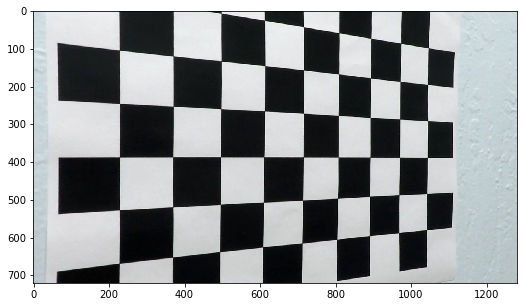

In [8]:
image = cv2.imread('camera_cal/calibration5.jpg')
plt.figure(figsize=(10, 5))
plt.imshow(cv2.undistort(image, mtx, dist, None, mtx))
plt.show()

In [17]:
n = 3    # The number of frames to average the fit coeffs
max_lost = 3    # The most frames where the lane detection is lost before a new search begins
# Set the width of the windows +/- margin
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 60 # How much to slide left and right for searching
video = 'road'
# Instantiate the lane objects
left_line = Line(n)
right_line = Line(n)
frame = Frame()

if video == 'road':
    road_output = 'road_test.mp4'
else:
    road_output = 'binary_test.mp4'
clip1 = VideoFileClip("project_video.mp4", audio=False)
road_clip = clip1.fl_image(run_centroid_search_pipeline)
%time road_clip.write_videofile(road_output, audio=False, verbose=0)


100%|█████████▉| 1260/1261 [07:43<00:00,  2.70it/s]


CPU times: user 8min 25s, sys: 1min 45s, total: 10min 10s
Wall time: 7min 44s
